In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Custom DF

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import cv2
from torchvision.transforms import ToPILImage
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from torchmetrics import AUROC
from torchmetrics.classification import BinaryAccuracy as Accuracy
from PIL import Image, ImageFilter
import random

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe=None, img_dir=None, for_train=True):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.for_train=for_train

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_dir + self.img_labels.iloc[idx, 0])
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        # threshold = random.randint(0, 100) / 100
        if self.transform:
            # if threshold < 0.5 and label == 0.0 and self.for_train is True:
            #     image = cv2.GaussianBlur(image,(5,5),0)
            #     label = 1.0
            image = self.transform(image)
        return image, label

In [ ]:
df = pd.read_csv('shift-cv-winter-2023/train.csv')
train_df, val_df = train_test_split(df, test_size=0.2)
# train_df = pd.read_csv('CFT_v2\CFT_train.csv')
# val_df = pd.read_csv('CFT_v2\CFT_val.csv')

In [ ]:
df_train = CustomImageDataset(train_df, 'shift-cv-winter-2023/train/train/')
train_loader = DataLoader(df_train, batch_size=32, shuffle=True)
df_val = CustomImageDataset(val_df, 'shift-cv-winter-2023/train/train/')
val_loader = DataLoader(df_val, batch_size=32)

(array([1077.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1054.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

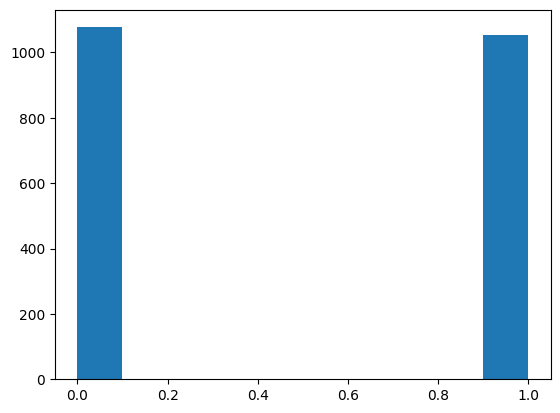

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_df['blur'])

(array([290.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 243.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

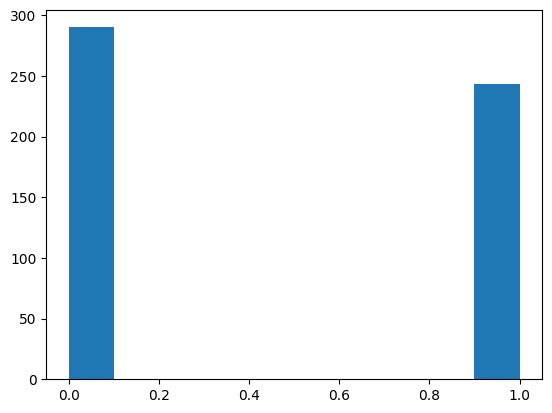

In [ ]:
plt.hist(val_df['blur'])

In [ ]:
# train_df.to_csv('CFT_train.csv')
# val_df.to_csv('CFT_val.csv')

In [ ]:
class MyModel(torch.nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    self.seq1 = torch.nn.Sequential(torch.nn.Sigmoid(),
                                    torch.nn.Linear(1000, 500),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(500, 200),
                                    torch.nn.Sigmoid(),
                                    torch.nn.Linear(200, 50),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(50, 2)
                                    )
    # self.sigm = torch.nn.Sigmoid()
  
  def forward(self, x):
    x = self.resnet50(x)
    x = self.seq1(x)
    return x # self.sigm(x)

In [ ]:
import torch.nn.functional as F
class FocalLoss(torch.nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight
        
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma*ce_loss).mean()
        
        return focal_loss

In [ ]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:<256>'

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(list(train_df['blur'])), y=list(train_df['blur']))
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)
epochs = 30
# tst = pd.read_csv('shift-cv-winter-2023/sample_submission.csv')
# df_test = CustomImageDataset(tst, 'shift-cv-winter-2023/test/test/')
# test_loader = DataLoader(df_test, 32, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2,verbose=True)
criterion = FocalLoss(weight=weights)
metric_aucroc = AUROC(task="binary").to(device)
metric_accuracy = Accuracy().to(device)

Using cache found in C:\Users\ROMMI/.cache\torch\hub\pytorch_vision_v0.10.0
e:\тестовые\CFT\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\тестовые\CFT\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train():
  
    model.train()

    total_loss = 0.0
  
    total_preds=[]

    acc_train = 0.0

    aucroc_ = 0.0
  
    for step,batch in enumerate(train_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))
        batch = [r.to(device) for r in batch]
        
        images, labels = batch

        labels = labels.type(torch.LongTensor).to(device)

        model.zero_grad() 
        
        preds = model(images)
        
        loss = criterion(preds, labels)

        total_loss = total_loss + loss.item()

        preds = torch.argmax(preds, dim = 1)

        aucroc_ += metric_aucroc(preds, labels.squeeze())
        acc_train += metric_accuracy(preds, labels.squeeze())
        
        loss.backward()
        optimizer.step()
        preds=preds.detach().cpu().numpy()

        total_preds.append(preds)

    avg_loss = total_loss / len(train_loader)

    avg_acc = acc_train / len(train_loader)

    avg_aucroc = aucroc_ / len(train_loader)

    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, avg_aucroc, total_preds

In [ ]:
def evaluate(loader):
  
    print("\nEvaluating...")
  
    model.eval()

    total_loss = 0.0
  
    total_preds = []

    acc_ = 0.0

    aucroc_ = 0.0

    for step,batch in enumerate(loader):
    
        if step % 50 == 0 and not step == 0:
                  
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(loader)))

        batch = [t.to(device) for t in batch]
        
        #faces, fulls, labels = batch
        images, labels = batch

        labels = labels.type(torch.LongTensor).to(device)

        with torch.no_grad():
      
            #preds = model(faces, fulls)
            preds = model(images)

            loss = criterion(preds,labels)

            total_loss = total_loss + loss.item()

            preds = torch.argmax(preds, dim = 1)

            aucroc_ += metric_aucroc(preds, labels.squeeze())

            acc_ += metric_accuracy(preds, labels.squeeze())

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    avg_loss = total_loss / len(loader) 

    avg_aucroc = aucroc_ / len(loader)

    avg_acc = acc_ / len(loader)

    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, avg_aucroc, total_preds

In [ ]:
device

device(type='cuda')

In [ ]:
from sklearn.metrics import f1_score
# set initial loss to infinite
best_valid_loss = float('inf')
best_valid_accuracy = float('-inf')
best_valid_aucroc = float('-inf')
best_valid_score = float('-inf')
model_loss = 0
model_accuracy = 0
model_aucroc = 0
model_score = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
train_accuracies=[]
train_aucrocs=[]
valid_losses=[]
valid_accuracies=[]
valid_aucrocs=[]
f_scores=[]
# test_losses=[]

# ys = list(filter_df(df_test.img_labels, False, True)['blur'])

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, train_acc, train_aucroc, _ = train()
    valid_loss, valid_acc, valid_aucroc, valid_preds = evaluate(val_loader)
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_loss = epoch
    if valid_acc > best_valid_accuracy:
      best_valid_accuracy = valid_acc
      model_accuracy = epoch
    if valid_aucroc > best_valid_aucroc:
      best_valid_aucroc = valid_aucroc
      model_aucroc = epoch
        
    torch.save(model.state_dict(), 'CFT_v7/models_v1/model' + str(epoch) + '.pt')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_aucrocs.append(train_aucroc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    valid_aucrocs.append(valid_aucroc)

    # valid_preds = np.argmax(valid_preds, axis = 1)

    f_score = f1_score(list(df_val.img_labels['blur']), valid_preds, average = 'binary')
    f_scores.append(f_score)
    if best_valid_score < f_score:
      best_valid_score = f_score
      model_score = epoch
    
    with open('CFT_v7/train_loss.txt', 'a') as f:
        f.write(str(train_loss) + '\n')
        
    with open('CFT_v7/valid_loss.txt', 'a') as f:
        f.write(str(valid_loss) + '\n')

    with open('CFT_v7/train_accuracy.txt', 'a') as f:
        f.write(str(train_acc) + '\n')
        
    with open('CFT_v7/valid_accuracy.txt', 'a') as f:
        f.write(str(valid_acc) + '\n')

    with open('CFT_v7/train_aucroc.txt', 'a') as f:
        f.write(str(train_aucroc) + '\n')
        
    with open('CFT_v7/valid_aucroc.txt', 'a') as f:
        f.write(str(valid_aucroc) + '\n')

        
    # test_loss, preds = evaluate(test_loader)
    # test_losses.append(test_loss)
    
    
    # with open('test_loss.txt', 'a') as f:
    #     f.write(str(test_loss) + '\n')
        
    # preds = np.argmax(preds, axis = 1)
    
    # f_score = f1_score(list(df_test.img_labels['blur']), preds, average = 'binary')
    

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'\nTraining AUROC: {train_aucroc:.3f}')
    print(f'\nValidation Loss: {valid_loss:.3f}')
    print(f'\nValidation Accuracy: {valid_acc:.3f}')
    print(f'\nValidation AUROC: {valid_aucroc:.3f}')
    print(f'\nF-score on val-set: {f_score:.3f}')

print(f'\nBest valid loss in epoch num {model_loss}: {best_valid_loss:.3f}')
print(f'\nBest valid accuracy in epoch num {model_accuracy}: {best_valid_accuracy:.3f}')
print(f'\nBest valid aucroc in epoch num {model_aucroc}: {best_valid_aucroc:.3f}')
print(f'\nBest valid score in epoch num {model_score}: {best_valid_score:.3f}')

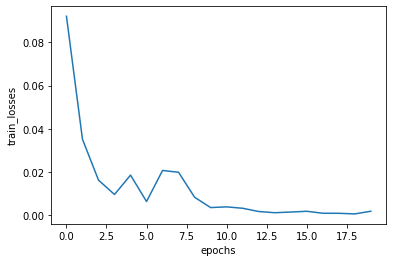

In [ ]:
plt.plot([i for i in range(epochs)], train_losses)
plt.xlabel('epochs')
plt.ylabel('train_losses')
plt.show()

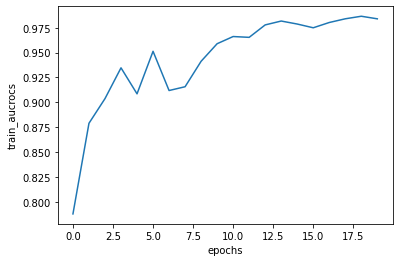

In [ ]:
train_aur = []
for aur in train_aucrocs:
  train_aur.append(aur.detach().cpu().numpy())
plt.plot([i for i in range(epochs)], train_aur)
plt.xlabel('epochs')
plt.ylabel('train_aucrocs')
plt.show()

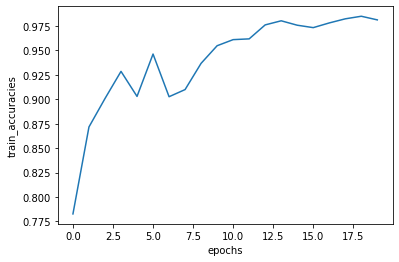

In [ ]:
train_accs = []
for acc in train_accuracies:
  train_accs.append(acc.detach().cpu().numpy())
plt.plot([i for i in range(epochs)], train_accs)
plt.xlabel('epochs')
plt.ylabel('train_accuracies')
plt.show()

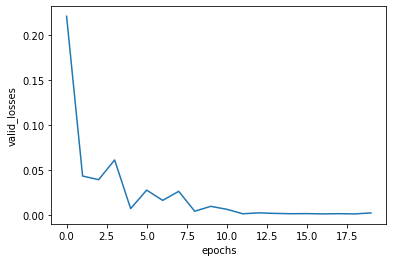

In [ ]:
plt.plot([i for i in range(epochs)], valid_losses)
plt.xlabel('epochs')
plt.ylabel('valid_losses')
plt.show()

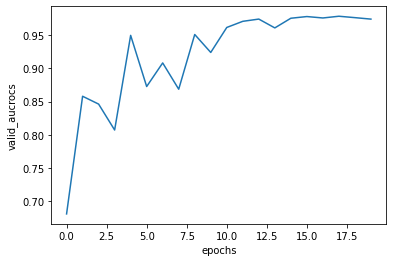

In [ ]:
valid_aur = []
for aur in valid_aucrocs:
  valid_aur.append(aur.detach().cpu().numpy())
plt.plot([i for i in range(epochs)], valid_aur)
plt.xlabel('epochs')
plt.ylabel('valid_aucrocs')
plt.show()

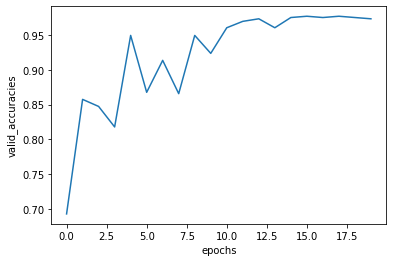

In [ ]:
valid_accs = []
for acc in valid_accuracies:
  valid_accs.append(acc.detach().cpu().numpy())
plt.plot([i for i in range(epochs)], valid_accs)
plt.xlabel('epochs')
plt.ylabel('valid_accuracies')
plt.show()

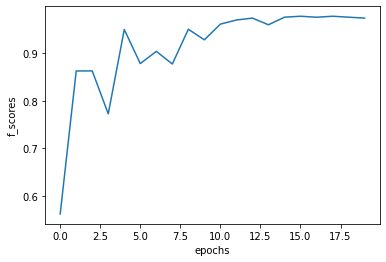

In [ ]:
plt.plot([i for i in range(epochs)], f_scores)
plt.xlabel('epochs')
plt.ylabel('f_scores')
plt.show()

In [ ]:
for f_score in f_scores:
  with open('f_scores.txt', 'a') as f:
        f.write(str(f_score) + '\n')

In [ ]:
model = MyModel().to(device)
checkpoint = torch.load('/content/models_v1/model17.pt')
model.load_state_dict(checkpoint)
tst = pd.read_csv('/content/drive/MyDrive/shift-cv-winter-2023/sample_submission.csv')
df_test = CustomImageDataset(tst, '/content/drive/MyDrive/shift-cv-winter-2023/test/test/')
test_loader = DataLoader(df_test, 32, shuffle=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
test_loss, test_acc, test_aucroc, test_preds = evaluate(test_loader)


Evaluating...


/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [ ]:
tst['blur'] = test_preds

In [ ]:
tst.head(26)

,filename,blur
0,bnxzvzqlzlnnbxfkcuin.jpg,0
1,powqsnpoynygwqsciedp.jpg,1
2,zpjlbfhurhygjnqccpii.jpg,0
3,klqqjqnnvyeemvkavivp.jpg,0
4,qwhvkcwctjllkdxaycvj.jpg,0
5,rotatyptdlbhvgylappa.jpg,0
6,oxreycouvsvrgwtdhpdh.jpg,1
7,xnhvzrldpchzofmqscae.jpg,0
8,mldswcksdrurhqxqtwhe.jpg,0
9,mhcfehkynsmohqgnkwbh.jpg,1


In [ ]:
tst.to_csv('test_v2.csv')